## 0) Imports and constants

In [20]:
import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import os
from copy import copy
matplotlib.rcParams.update({'figure.autolayout': True})

In [21]:
# %matplotlib inline
SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [69]:
mainDir = "C://Users//JosephVermeil//Desktop//ActinCortexAnalysis"
experimentalDataDir = os.path.join(mainDir, "ExperimentalData")
dataDir = os.path.join(mainDir, "DataAnalysis")
timeSeriesDataDir = os.path.join(dataDir, "TimeSeriesData")
allTimeSeriesDataFiles = [f for f in os.listdir(timeSeriesDataDir) if (os.path.isfile(os.path.join(timeSeriesDataDir, f)) and f.endswith(".csv"))]
allTimeSeriesDataFiles

['20-08-04_M1_P1_C5_R40.csv',
 '20-08-04_M1_P1_C6_R40.csv',
 '20-08-04_M1_P1_C7_R40.csv',
 '20-08-04_M2_P1_C3_R40.csv',
 '20-08-04_M2_P1_C4_R40.csv',
 '20-08-04_M2_P1_C5_R40.csv',
 '20-08-05_M1_P1_C32_R40.csv',
 '20-08-05_M1_P1_C3_R40.csv',
 '20-08-05_M1_P1_C4_R40.csv',
 '20-08-05_M1_P1_C5_R40.csv',
 '20-08-05_M1_P1_C6_R40.csv',
 '20-08-05_M1_P1_C7_R40.csv',
 '20-08-05_M1_P1_C8_R40.csv',
 '20-08-05_M2_P1_C2_R40.csv',
 '20-08-05_M2_P1_C3_R40.csv',
 '20-08-05_M2_P1_C4_R40.csv',
 '20-08-05_M2_P1_C5_R40.csv',
 '20-08-05_M2_P1_C6_R40.csv',
 '20-08-05_M2_P1_C7_R40.csv',
 '20-08-07_M1_P1_C3_R40.csv',
 '20-08-07_M1_P1_C4_R40.csv',
 '20-08-07_M1_P1_C62_R40.csv',
 '20-08-07_M1_P1_C6_R40.csv',
 '20-08-07_M1_P1_C7_R40.csv',
 '20-08-07_M1_P1_C8_R40.csv',
 '20-08-07_M2_P1_C4_R40.csv',
 '20-08-07_M2_P1_C5_R40.csv',
 '20-08-07_M2_P1_C6_R40.csv',
 '20-08-07_M2_P1_C7_R40.csv',
 '21-01-18_M1_P1_C1_R40_disc20um.csv',
 '21-01-18_M1_P1_C2_R40_disc20um.csv',
 '21-01-18_M1_P1_C3_R40_disc20um.csv',
 '21-01-18_

In [99]:
def get_R2(Y1, Y2):
    meanY = np.mean(Y1)
    meanYarray = meanY*np.ones(len(Y1))
    SST = np.sum((Y1-meanYarray)**2)
    SSE = np.sum((Y2-meanYarray)**2)
    R2 = SSE/SST
    return(R2)

## 1) TimeSeries functions

In [70]:
def getCellTimeSeriesData(cellID):
    allTimeSeriesDataFiles = [f for f in os.listdir(timeSeriesDataDir) if (os.path.isfile(os.path.join(timeSeriesDataDir, f)) and f.endswith(".csv"))]
    fileFound = False
    nFile = len(allTimeSeriesDataFiles)
    iFile = 0
    while (not fileFound) and (iFile < nFile):
        f = allTimeSeriesDataFiles[iFile]
        if f.startswith(cellID):
            timeSeriesDataFilePath = os.path.join(timeSeriesDataDir, f)
            timeSeriesDataFrame = pd.read_csv(timeSeriesDataFilePath, sep=';')
            fileFound = True
        iFile += 1
    if not fileFound:
        timeSeriesDataFrame = pd.DataFrame([])
    return(timeSeriesDataFrame)

def plotCellTimeSeriesData(cellID):
    X = 'T'
    Y = np.array(['B', 'F', 'dx', 'dy', 'dz', 'D2', 'D3'])
    units = np.array([' (mT)', ' (pN)', ' (µm)', ' (µm)', ' (µm)', ' (µm)', ' (µm)'])
    timeSeriesDataFrame = getCellTimeSeriesData(cellID)
    if not timeSeriesDataFrame.size == 0:
#         plt.tight_layout()
#         fig.show() # figsize=(20,20)
        axes = timeSeriesDataFrame.plot(x=X, y=Y, kind='line', ax=None, subplots=True, sharex=True, sharey=False, layout=None, \
                       figsize=(8,10), use_index=True, title = cellID + '- Time dependant data', grid=None, legend=False, style=None, logx=False, logy=False, \
                       loglog=False, xticks=None, yticks=None, xlim=None, ylim=None, rot=None, fontsize=None, colormap=None, \
                       table=False, yerr=None, xerr=None, secondary_y=False, sort_columns=False)
        plt.gcf().tight_layout()
        for i in range(len(Y)):
            axes[i].set_ylabel(Y[i] + units[i])
        
    else:
        print('cell not found')
        
def addExcludedCell(cellID, motive):
    f = open(os.path.join(experimentalDataDir, 'ExcludedCells.txt'), 'r')
    lines = f.readlines()
    nLines = len(lines)
    excludedCellsList = []
    for iLine in range(nLines):
        line = lines[iLine]
        splitLine = line[:-1].split(',')
        excludedCellsList.append(splitLine[0])
    if cellID in excludedCellsList:
        newlines = copy(lines)
        iLineOfInterest = excludedCellsList.index(cellID)
        if motive not in newlines[iLineOfInterest][:-1].split(','):
            newlines[iLineOfInterest] = newlines[iLineOfInterest][:-1] + ',' + motive + '\n'            
    else:
        newlines = copy(lines)
        newlines.append('' + cellID + ',' + motive + '\n')
    f.close()
    f = open(os.path.join(experimentalDataDir, 'ExcludedCells.txt'), 'w')
    f.writelines(newlines)
    
def getExcludedCells():
    f = open(os.path.join(experimentalDataDir, 'ExcludedCells.txt'), 'r')
    lines = f.readlines()
    nLines = len(lines)
    excludedCellsDict = {}
    for iLine in range(nLines):
        line = lines[iLine]
        splitLine = line[:-1].split(',')
        excludedCellsDict[splitLine[0]] = splitLine[1:]
    return(excludedCellsDict)

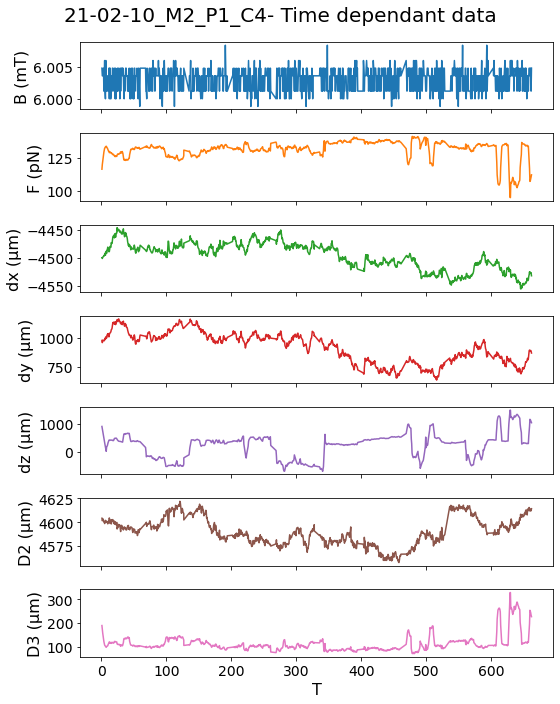

In [119]:
df = getCellTimeSeriesData('21-02-10_M1_P1_C1')
plotCellTimeSeriesData('21-02-10_M2_P1_C4')

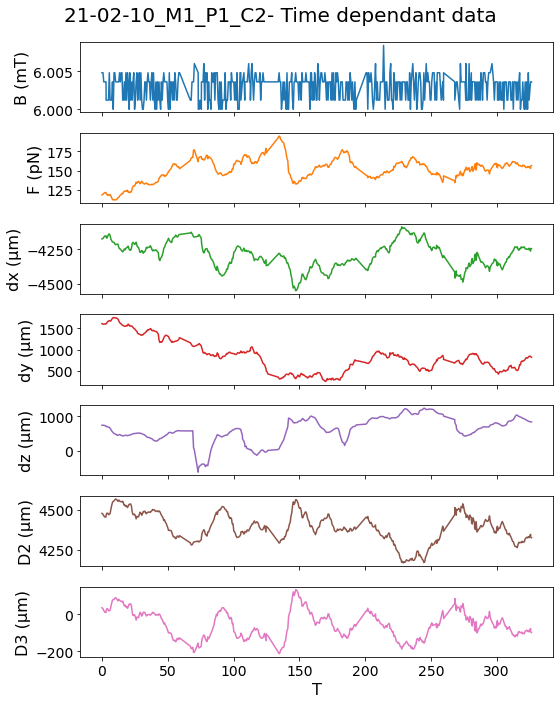

In [117]:
plotCellTimeSeriesData('21-02-10_M1_P1_C2')

0.22299373039696993

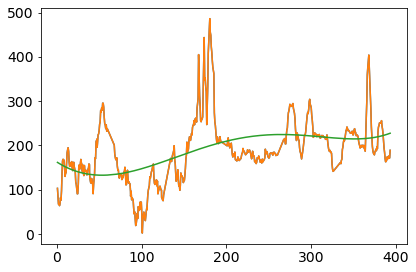

In [109]:
T = df['T']
Y = df['D3']
plt.plot(T,Y)
p, residuals, rank, singular_values, rcond = np.polyfit(T, Y, deg=5, full=True)
plt.plot(T, Y)
Y2 = np.zeros(len(T))
for i in range(len(T)):
    deg = len(p)-1
    for k in range(deg+1):
        Y2[i] += p[k]*(T[i]**(deg-k))
plt.plot(T,Y2)
get_R2(Y, Y2)

## 2) GlobalTables functions

### a) Experimental conditions

In [74]:
def getExperimentalConditions():
    # Getting the table
    experimentalDataFile = 'ExperimentalConditions.csv'
    experimentalDataFilePath = os.path.join(experimentalDataDir, experimentalDataFile)
    expConditionsDF = pd.read_csv(experimentalDataFilePath, sep=';',header=1)
    print('Extracted a table with ' + str(expConditionsDF.shape[0]) + ' lines and ' + str(expConditionsDF.shape[1]) + ' columns.')
    # Cleaning the table
#     try:
    expConditionsDF = expConditionsDF.convert_dtypes()

    listTextColumns = []
    for col in expConditionsDF.columns:
        if expConditionsDF[col].dtype == 'string':
            listTextColumns.append(col)

    expConditionsDF[listTextColumns] = expConditionsDF[listTextColumns].apply(lambda x: x.str.replace(',','.'))

    expConditionsDF['scale pixel per um'] = expConditionsDF['scale pixel per um'].astype(float)
    expConditionsDF['optical index correction'] = \
              expConditionsDF['optical index correction'].apply(lambda x: x.split('/')[0]).astype(float) \
            / expConditionsDF['optical index correction'].apply(lambda x: x.split('/')[1]).astype(float)
    expConditionsDF['magnetic field correction'] = expConditionsDF['magnetic field correction'].astype(float)
    expConditionsDF['with fluo images'] = expConditionsDF['with fluo images'].astype(bool)

    expConditionsDF['ramp field'] = \
    expConditionsDF['ramp field'].apply(lambda x: [x.split(';')[0], x.split(';')[1]] if not pd.isnull(x) else [])

#     except:
#         print('Unexpected bug with the cleaning step')
    return(expConditionsDF)

### b) Constant Field

In [110]:
def analyseTimeSeries_ctField(tS_df):
    results = {}
    results['duration'] = np.max(tS_df['T'])
    results['medianRawB'] = np.median(tS_df.B)
    results['medianThickness'] = np.median(tS_df.D3)
    results['1stDThickness'] = np.percentile(tS_df.D3, 10)
    results['9thDThickness'] = np.percentile(tS_df.D3, 90)
    results['fluctuAmpli'] = results['9thDThickness'] - results['1stDThickness']
    results['validated'] = (results['1stDThickness'] > 0)
    X, Y = tS_df['T'], tS_df['D3']
    p, residuals, rank, singular_values, rcond = np.polyfit(X, Y, deg=5, full=True)
    Y2 = np.zeros(len(X))
    for i in range(len(X)):
        deg = len(p)-1
        for k in range(deg+1):
            Y2[i] += p[k]*(X[i]**(deg-k))
    results['R2_polyFit'] = get_R2(Y, Y2)
    return(results)

def createCtFieldDataDict(list_ctFieldFiles):
    tableDict = {}
    tableDict['date'], tableDict['cellName'], tableDict['cellID'] = [], [], []
    tableDict['duration'], tableDict['medianRawB'], tableDict['medianThickness'] = [], [], []
    tableDict['1stDThickness'], tableDict['9thDThickness'], tableDict['fluctuAmpli'] = [], [], []
    tableDict['R2_polyFit'], tableDict['validated'] = [], []
    for f in list_ctFieldFiles:
        split_f = f.split('_')
        tableDict['date'].append(split_f[0])
        tableDict['cellName'].append(split_f[1] + '_' + split_f[2] + '_' + split_f[3])
        tableDict['cellID'].append(split_f[0] + '_' + split_f[1] + '_' + split_f[2] + '_' + split_f[3])
        tS_DataFilePath = os.path.join(timeSeriesDataDir, f)
        current_tS_df = pd.read_csv(tS_DataFilePath, ';')
        current_resultDict = analyseTimeSeries_ctField(current_tS_df)
        for k in current_resultDict.keys():
            tableDict[k].append(current_resultDict[k])
    return(tableDict)

def computeGlobalTable_ctField(task = 'fromScratch', fileName = 'Global_CtFieldData', save = True):
    ctFieldTimeSeriesDataFiles = [f for f in os.listdir(timeSeriesDataDir) \
                                  if (os.path.isfile(os.path.join(timeSeriesDataDir, f)) and f.endswith(".csv") \
                                      and ('thickness' in f))]
#     print(ctFieldTimeSeriesDataFiles)
    if task == 'fromScratch':
        # create a dict containing the data
        tableDict = createCtFieldDataDict(ctFieldTimeSeriesDataFiles)
        # create the table
        CtField_DF = pd.DataFrame(tableDict)
        
    elif task == 'updateExisting':
        # get existing table
        try:
            savePath = os.path.join(dataDir, (fileName + '.csv'))
            existing_CtField_DF = pd.read_csv(savePath, sep=';')
        except:
            print('No existing table found')
        # find which of the time series files are new
        new_ctFieldTimeSeriesDataFiles = []
        for f in ctFieldTimeSeriesDataFiles:
            split_f = f.split('_')
            currentCellID = split_f[0] + '_' + split_f[1] + '_' + split_f[2] + '_' + split_f[3]
            if currentCellID not in existing_CtField_DF.cellID:
                new_ctFieldTimeSeriesDataFiles.append(f)
        new_tableDict = createCtFieldDataDict(new_ctFieldTimeSeriesDataFiles)
        # create the table with new data
        new_CtField_DF = pd.dataframe(tableDict)
        # fuse the two
        CtField_DF = pd.concat([existing_CtField_DF, new_CtField_DF])
        
    if save:
        saveName = fileName + '.csv'
        savePath = os.path.join(dataDir, saveName)
        CtField_DF.to_csv(savePath, sep=';')
        
    return(CtField_DF)
            
            
def getGlobalTable_ctField(fileName = 'Global_CtFieldData'):
    try:
        savePath = os.path.join(dataDir, (fileName + '.csv'))
        CtField_DF = pd.read_csv(savePath, sep=';')
        print('Extracted a table with ' + str(CtField_DF.shape[0]) + ' lines and ' + str(CtField_DF.shape[1]) + ' columns.')
    except:
        print('No existing table found')
    return(CtField_DF)

In [112]:
computeGlobalTable_ctField()

,date,cellName,cellID,duration,medianRawB,medianThickness,1stDThickness,9thDThickness,fluctuAmpli,R2_polyFit,validated
0,21-02-10,M1_P1_C1,21-02-10_M1_P1_C1,393.550,6.0036,183.232388,103.105084,276.671473,173.566389,0.222994,True
1,21-02-10,M1_P1_C2,21-02-10_M1_P1_C2,326.388,6.0036,-58.229968,-147.203983,41.303068,188.507051,0.228033,False
2,21-02-10,M1_P1_C3,21-02-10_M1_P1_C3,327.997,6.0036,204.963636,123.738478,277.782516,154.044039,0.402168,True
3,21-02-10,M1_P1_C4,21-02-10_M1_P1_C4,326.929,6.0036,203.321336,165.769700,282.439284,116.669585,0.261129,True
4,21-02-10,M1_P1_C5,21-02-10_M1_P1_C5,260.260,6.0036,231.480125,169.220846,301.601770,132.380924,0.248455,True
5,21-02-10,M1_P1_C6,21-02-10_M1_P1_C6,668.892,6.0036,216.957868,94.708414,445.651685,350.943271,0.428523,True
6,21-02-10,M1_P1_C7,21-02-10_M1_P1_C7,669.504,6.0036,128.845941,93.280219,198.677785,105.397565,0.554638,True
7,21-02-10,M1_P1_C8,21-02-10_M1_P1_C8,670.202,6.0036,131.625197,80.148395,210.220970,130.072575,0.537598,True
8,21-02-10,M2_P1_C2,21-02-10_M2_P1_C2,661.131,6.0036,200.150152,154.525695,259.050063,104.524368,0.225815,True
9,21-02-10,M2_P1_C3,21-02-10_M2_P1_C3,327.173,6.0036,330.390733,170.522187,1017.811562,847.289375,0.923930,True


In [66]:
# Old code
conditions = ['nodrug', 'doxy']
correspondance = {conditions[0] : 'M1', conditions[1] : 'M2'}
allTimeSeriesDataFiles = [f for f in os.listdir(timeSeriesDataDir) if (os.path.isfile(os.path.join(timeSeriesDataDir, f)) and f.endswith(".txt"))]
dates = ['21-02-10']
resDict = {conditions[0] : {}, conditions[1] : {}}
for C in conditions:
    resDict[C]['accepted'] = []
    resDict[C]['rejected'] = []
    resDict[C]['median'] = []
    resDict[C]['fluctu'] = []
    for D in dates:
        for f in allTimeSeriesDataFiles:
            if correspondance[C] in f and D in f:
                split_f = f.split('_')
                cellID = split_f[0] + '_' + split_f[1] + '_' + split_f[2] + '_' + split_f[3]
                currentCellTS = getCellTimeSeriesData(cellID)
                D3 = currentCellTS.D3.values
                decile_1 = np.percentile(D3, 10)
                median = np.median(D3)
                decile_9 = np.percentile(D3, 90)
                if decile_1 < 0:
                    resDict[C]['rejected'].append(cellID)
                else:
                    resDict[C]['accepted'].append(cellID)
                    resDict[C]['median'].append(median)
                    resDict[C]['fluctu'].append(decile_9-decile_1)
#resDict

### c) Meca data

# TBC

In [68]:
def analyseTimeSeries_meca(tS_df):
    results = {}
    ### TBC
    return(results)

def createMecaDataDict(list_ctFieldFiles):
    tableDict = {}
    tableDict['date'], tableDict['cellName'], tableDict['cellID'] = [], [], []
#     tableDict[''], tableDict[''], tableDict[''] = [], [], []
#     tableDict[''], tableDict[''], tableDict[''] = [], [], []
#     tableDict[''] = []
# TBC
    for f in list_ctFieldFiles:
        split_f = f.split('_')
        tableDict['date'].append(split_f[0])
        tableDict['cellName'].append(split_f[1] + '_' + split_f[2] + '_' + split_f[3])
        tableDict['cellID'].append(split_f[0] + '_' + split_f[1] + '_' + split_f[2] + '_' + split_f[3])
        tS_DataFilePath = os.path.join(timeSeriesDataDir, f)
        current_tS_df = pd.read_csv(tS_DataFilePath, ';')
        current_resultDict = analyseTimeSeries_meca(current_tS_df)
        for k in current_resultDict.keys():
            tableDict[k].append(current_resultDict[k])
    return(tableDict)

def computeGlobalTable_meca(task = 'fromScratch', fileName = 'Global_CtFieldData', save = True):
    mecaTimeSeriesDataFiles = [f for f in os.listdir(timeSeriesDataDir) \
                                  if (os.path.isfile(os.path.join(timeSeriesDataDir, f)) and f.endswith(".csv") \
                                      and ('R40' in f))] # Change to allow different formats in the future
    print(ctFieldTimeSeriesDataFiles)
    if task == 'fromScratch':
        # create a dict containing the data
        tableDict = createMecaDataDict(mecaTimeSeriesDataFiles)
        # create the table
        meca_DF = pd.DataFrame(tableDict)
        
    elif task == 'updateExisting':
        # get existing table
        try:
            savePath = os.path.join(dataDir, (fileName + '.csv'))
            existing_meca_DF = pd.read_csv(savePath, sep=';')
        except:
            print('No existing table found')
        # find which of the time series files are new
        new_mecaTimeSeriesDataFiles = []
        for f in mecaTimeSeriesDataFiles:
            split_f = f.split('_')
            currentCellID = split_f[0] + '_' + split_f[1] + '_' + split_f[2] + '_' + split_f[3]
            if currentCellID not in existing_meca_DF.cellID:
                new_mecaTimeSeriesDataFiles.append(f)
        new_tableDict = createCtFieldDataDict(new_mecaTimeSeriesDataFiles)
        # create the table with new data
        new_meca_DF = pd.dataframe(tableDict)
        # fuse the two
        meca_DF = pd.concat([existing_meca_DF, new_meca_DF])
        
    if save:
        saveName = fileName + '.csv'
        savePath = os.path.join(dataDir, saveName)
        meca_DF.to_csv(savePath, sep=';')
        
    return(meca_DF)
            
            
def getGlobalTable_meca(fileName = 'Global_mecaData'):
    try:
        savePath = os.path.join(dataDir, (fileName + '.csv'))
        meca_DF = pd.read_csv(savePath, sep=';')
        print('Extracted a table with ' + str(meca_DF.shape[0]) + ' lines and ' + str(meca_DF.shape[1]) + ' columns.')
    except:
        print('No existing table found')
    return(meca_DF)

### d) Fluorescence

### e) Data formatting and filtering

In [32]:
mecaDataFile = 'Global_MecaData.txt'
mecaDataFilePath = os.path.join(dataDir, mecaDataFile)
mecaDF = pd.read_csv(mecaDataFilePath, sep=',')
print('Extracted a table with ' + str(mecaDF.shape[0]) + ' lines and ' + str(mecaDF.shape[1]) + ' columns.')

mecaDF = mecaDF.rename(columns={"CellID": "CellName", "CellName": "CellID"})

Extracted a table with 5083 lines and 20 columns.


In [34]:
# mecaDF

In [63]:
experimentalDataFile = 'ExperimentalConditions.csv'
experimentalDataFilePath = os.path.join(experimentalDataDir, experimentalDataFile)
expConditionsDF = pd.read_csv(experimentalDataFilePath, sep=';',header=1)
print('Extracted a table with ' + str(expConditionsDF.shape[0]) + ' lines and ' + str(expConditionsDF.shape[1]) + ' columns.')

# Cleaning the table
try:
    expConditionsDF = expConditionsDF.convert_dtypes()

    listTextColumns = []
    for col in expConditionsDF.columns:
        if expConditionsDF[col].dtype == 'string':
            listTextColumns.append(col)

    expConditionsDF[listTextColumns] = expConditionsDF[listTextColumns].apply(lambda x: x.str.replace(',','.'))

    expConditionsDF['scale pixel per um'] = expConditionsDF['scale pixel per um'].astype(float)
    expConditionsDF['optical index correction'] = \
              expConditionsDF['optical index correction'].apply(lambda x: x.split('/')[0]).astype(float) \
            / expConditionsDF['optical index correction'].apply(lambda x: x.split('/')[1]).astype(float)
    expConditionsDF['magnetic field correction'] = expConditionsDF['magnetic field correction'].astype(float)
    expConditionsDF['with fluo images'] = expConditionsDF['with fluo images'].astype(bool)

    expConditionsDF['ramp field'] = \
    expConditionsDF['ramp field'].apply(lambda x: [x.split(';')[0], x.split(';')[1]] if not pd.isnull(x) else [])

except:
    print('Unexpected bug with the cleaning step')

Extracted a table with 30 lines and 20 columns.


In [12]:
# expConditionsDF

In [13]:
# Unused for now
cellDescriptionDataFile = 'CellDescription.csv'
cellDescriptionDataFilePath = os.path.join(experimentalDataDir, cellDescriptionDataFile)
cellDescriptionDF = pd.read_csv(cellDescriptionDataFilePath, ',')
print('Extracted a table with ' + str(cellDescriptionDF.shape[0]) + ' lines and ' + str(cellDescriptionDF.shape[1]) + ' columns.')

Extracted a table with 58 lines and 14 columns.


In [14]:
mecaDF['ManipID'] = mecaDF['ExpDay'] + '_' + mecaDF['CellName'].apply(lambda x: x.split('_')[0])
expConditionsDF['ManipID'] = expConditionsDF['date'] + '_' + expConditionsDF['manip']

mainMecaDF = pd.merge(
    expConditionsDF,
    mecaDF,
    how="inner",
    on='ManipID',
#     left_on=None,
#     right_on=None,
#     left_index=False,
#     right_index=False,
#     sort=True,
#     suffixes=("_x", "_y"),
#     copy=True,
#     indicator=False,
#     validate=None,
)

In [15]:
# pd.set_option('display.max_columns', None)
# mainMecaDF.head()

In [16]:
pd.reset_option('max_columns')

#### * Data filtering

In [ ]:
# pd.set_option('display.max_columns', None)
# mainMecaDF.head()

In [ ]:
# pd.reset_option('max_columns')
# mainMecaDF.columns

In [ ]:
mainMecaDF_f = mainMecaDF.loc[(mainMecaDF["Validated"] == 1)]
# mainMecaDF_f

In [ ]:
%matplotlib inline
listCells = mainMecaDF_f['CellID'].drop_duplicates().astype('string').values
timeSeriesDict = {}
for cell in listCells:
    currentCell_TimeSeriesData = getCellTimeSeriesData(cell)
    timeSeriesDict[cell] = currentCell_TimeSeriesData
start, stop = 80, 100
fig, axes = plt.subplots((stop-start),1, figsize = (7,4*(stop-start)))
fig.tight_layout()
for k in range(start, stop):
    if k < len(listCells):
        currentCell_TimeSeriesData = timeSeriesDict[listCells[k]]
        T = currentCell_TimeSeriesData['T'].values
        idxCompression = currentCell_TimeSeriesData['idxCompression'].values
        D3 = currentCell_TimeSeriesData['D3'].values
        maskConstant = (idxCompression == 0)
        maskCompression = (idxCompression > 0)
        axes[k - start].plot(T, D3*1000-4503, 'k-', linewidth = 0.5)
        axes[k - start].plot(T[maskCompression], D3[maskCompression]*1000-4503, 'ro', markersize=2)
        axes[k - start].plot(T[maskConstant], D3[maskConstant]*1000-4503, 'co', markersize=2)
        axes[k - start].set_title(listCells[k])
        axes[k - start].set_xlabel('T (s)')
        axes[k - start].set_ylabel('D3 (µm)')

In [ ]:
addExcludedCell('21-01-18_M1_P1_C2', 'passive')
addExcludedCell('21-01-18_M1_P1_C3', 'passive')
addExcludedCell('21-01-18_M1_P1_C4', 'passive')
addExcludedCell('21-01-21_M3_P1_C4', 'passive')
addExcludedCell('21-01-21_M3_P1_C5', 'passive')
addExcludedCell('20-08-07_M1_P1_C6', 'too thick')
addExcludedCell('20-08-07_M1_P1_C62', 'too thick')

excludedCellsDict = getExcludedCells()
# excludedMask = (mainMecaDF_f["CellID"].values not in excludedCellsDict.keys())
# mainMecaDF_f = mainMecaDF_f.loc[(mainMecaDF_f["CellID"].values not in excludedCellsDict.keys())]
for i in range(len(excludedCellsDict)):
    print('a')
mainMecaDF_f["CellID"].drop_duplicates().astype('string').values

In [ ]:
currentCell_TimeSeriesData

In [ ]:
mainMecaDF_GroupedPerCell = mainMecaDF_f.groupby('CellID')
mainMecaDF_DataPerCell = mainMecaDF_GroupedPerCell.agg({"EChadwick": np.median, "SurroundingThickness": np.median, "H0Chadwick" : np.median})
# mainMecaDF_GroupedPerCell.agg({"EChadwick": np.median, "D": lambda x: np.std(x, ddof=1)})
cols = ['date', 'manip', 'experimentType', 'drug', 'substrate',
       'objective magnification', 'scale pixel per um', 'objective immersion',
       'optical index correction', 'magnetic field correction', 'cell type',
       'cell subtype', 'bead type', 'bead diameter', 'normal field',
       'ramp field', 'compression duration', 'with fluo images', 'comments',
       'ManipID', 'ExpType', 'CellName', 'CellID']
mainMecaDF_DataPerCell.dropna(inplace = True)
mainMecaDF_DataPerCell = pd.merge(mainMecaDF_DataPerCell,
                                  mainMecaDF_f[cols].drop_duplicates(subset=['CellID']),
                                  how="inner",
                                  on='CellID',
                                  #     left_on='CellID',
                                  #     right_on='CellID',
                                  #     left_index=False,
                                  #     right_index=False,
                                  #     sort=True,
                                  #     suffixes=("_x", "_y"),
                                  #     copy=True,
                                  #     indicator=False,
                                  #     validate=None,
                                  )
# mainMecaDF_DataPerCell

In [ ]:
mainMecaDF_DataPerCell_Count = mainMecaDF_DataPerCell.groupby(['cell type', 'cell subtype', 'bead type', 'drug', 'substrate']).count()
mainMecaDF_DataPerCell_Count.loc[:, ['CellID']].rename(columns={'CellID' : 'Count'})

## 3) Plots

C:\Users\JosephVermeil\anaconda3\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  from ipykernel import kernelapp as app


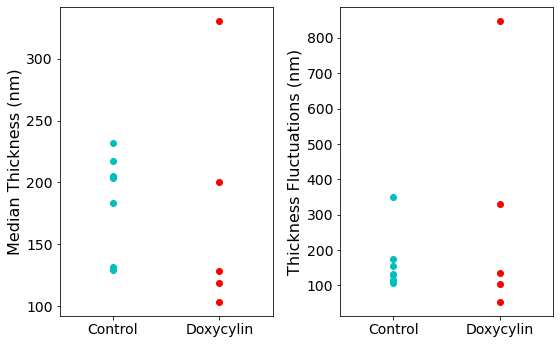

In [27]:
fig, axes = plt.subplots(1,2, figsize = (8, 5))
axes[0].plot(np.ones(len(resDict['nodrug']['median'])), resDict['nodrug']['median'], 'co')
axes[0].plot(2*np.ones(len(resDict['doxy']['median'])), resDict['doxy']['median'], 'ro')
axes[0].set_xlim(0.5, 2.5)
axes[0].set_ylabel('Median Thickness (nm)')
axes[0].set_xticks([1,2])
axes[0].set_xticklabels(['Control','Doxycylin'])
axes[1].plot(np.ones(len(resDict['nodrug']['fluctu'])), resDict['nodrug']['fluctu'], 'co')
axes[1].plot(2*np.ones(len(resDict['doxy']['fluctu'])), resDict['doxy']['fluctu'], 'ro')
axes[1].set_xlim(0.5, 2.5)
axes[1].set_ylabel('Thickness Fluctuations (nm)')
axes[1].set_xticks([1,2])
axes[1].set_xticklabels(['Control','Doxycylin'])
fig.savefig("C://Users//JosephVermeil//Desktop//ActinCortexAnalysis//DataAnalysis//constantField.png")
fig.show()